In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


In [5]:
DATA_ROOT = os.path.expanduser("../data")
TILE_DIR  = os.path.join(DATA_ROOT, "rubin_tiles_ecdfs_gr_i")

files = sorted(glob.glob(os.path.join(TILE_DIR, "*.npz")))
len(files), files[:3]

(144,
 ['../data/rubin_tiles_ecdfs_gr_i/tile_x00000_y00000.npz',
  '../data/rubin_tiles_ecdfs_gr_i/tile_x00000_y00256.npz',
  '../data/rubin_tiles_ecdfs_gr_i/tile_x00000_y00512.npz'])

In [6]:
f = np.load(files[0])
print(f.files)

img  = f["img"]   # [B,H,W]
var  = f["var"]
mask = f["mask"]

img.shape, var.shape, mask.shape



['img', 'var', 'mask', 'wcs_hdr', 'x0', 'y0']


((3, 512, 512), (3, 512, 512), (3, 512, 512))

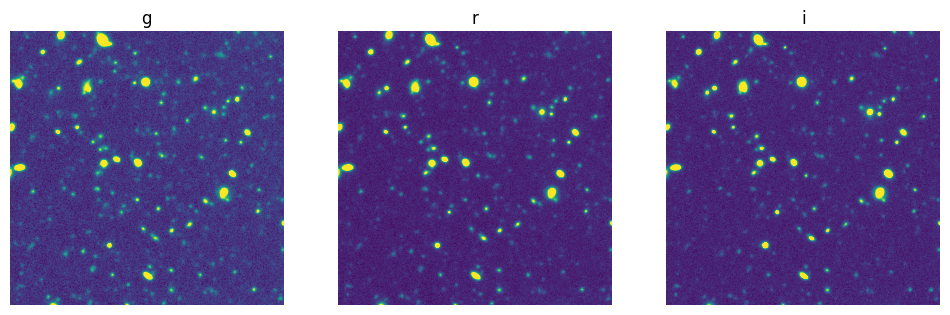

In [7]:
bands = ["g", "r", "i"]

fig, axs = plt.subplots(1, img.shape[0], figsize=(12,4))
for i, ax in enumerate(axs):
    lo, hi = np.percentile(img[i], (1,99))
    ax.imshow(img[i], origin="lower", vmin=lo, vmax=hi)
    ax.set_title(bands[i])
    ax.axis("off")
plt.show()


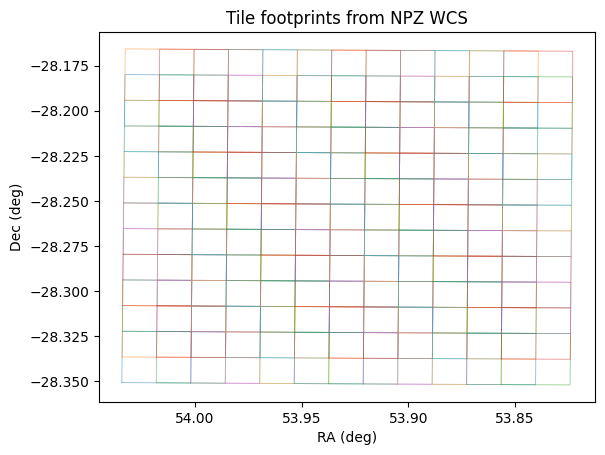

In [13]:

import os, glob
import numpy as np
import matplotlib.pyplot as plt
from astropy.wcs import WCS

TILE_DIR = os.path.expanduser("../data/rubin_tiles_ecdfs_gr_i")
files = sorted(glob.glob(os.path.join(TILE_DIR, "*.npz")))
len(files), files[:3]

def wcs_from_npz_wcs_hdr(wcs_hdr):
    """
    wcs_hdr is stored as a dict in the NPZ. Turn it into an astropy.wcs.WCS.
    """
    # np.load gives object arrays sometimes; ensure plain dict
    if isinstance(wcs_hdr, np.ndarray) and wcs_hdr.dtype == object:
        wcs_hdr = wcs_hdr.item()
    return WCS(wcs_hdr)

def tile_footprint_radec(npz_path):
    z = np.load(npz_path, allow_pickle=True)
    img = z["img"]
    H, W = img.shape[-2], img.shape[-1]

    w = wcs_from_npz_wcs_hdr(z["wcs_hdr"])

    # pixel corners (0-indexed pixel coordinates in the cutout)
    # corners in order: (0,0) (W,0) (W,H) (0,H) and close polygon
    px = np.array([0, W, W, 0, 0], dtype=float)
    py = np.array([0, 0, H, H, 0], dtype=float)

    ra, dec = w.wcs_pix2world(px, py, 0)  # origin=0 for 0-indexed
    return ra, dec

    plt.figure(figsize=(8,8))

# If many tiles, plot a subset first
use = files[:200]  # adjust

for fp in use:
    ra, dec = tile_footprint_radec(fp)

    # RA wrap handling: for small fields it's usually fine, but this keeps it stable
    ra = np.unwrap(np.deg2rad(ra))
    ra = np.rad2deg(ra)

    plt.plot(ra, dec, lw=0.6, alpha=0.5)

plt.gca().invert_xaxis()  # standard sky convention: RA increases to the left
plt.xlabel("RA (deg)")
plt.ylabel("Dec (deg)")
plt.title("Tile footprints from NPZ WCS")
plt.show()



In [8]:
class RubinTileDataset(Dataset):
    def __init__(self, tile_dir):
        self.files = sorted(glob.glob(os.path.join(tile_dir, "*.npz")))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        f = np.load(self.files[idx])
        img = torch.from_numpy(f["img"]).float()   # [B,H,W]
        var = torch.from_numpy(f["var"]).float()
        msk = torch.from_numpy(f["mask"]).long()
        return img, var, msk

ds = RubinTileDataset(TILE_DIR)
dl = DataLoader(ds, batch_size=2, shuffle=True, num_workers=2)

img, var, msk = next(iter(dl))
img.shape, var.shape, msk.shape


(torch.Size([2, 3, 512, 512]),
 torch.Size([2, 3, 512, 512]),
 torch.Size([2, 3, 512, 512]))

In [9]:
class TinyConv(nn.Module):
    def __init__(self, in_ch=3, out_ch=16):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, 16, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, out_ch, 3, padding=1),
        )

    def forward(self, x):
        return self.net(x)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = TinyConv().to(device)

img = img.to(device)
var = var.to(device)

out = model(img)
loss = (out**2).mean()   # dummy loss

loss.backward()
loss.item()



20665.88671875